In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb
from sklearn import metrics

In [2]:
user = 'cchang'

In [3]:
hop_sec = 512 * 1 / 22050
n_cores = 8
downsample = 1

In [4]:
ANNOTATIONS_ROOT_CLEAN = Path('/home/{}/ttmp/raw_data/Chopin_Mazurkas/annotations_beat'.format(user))
FEATURES_ROOT_CLEAN = Path('/home/{}/ttmp/features/clean'.format(user))

In [5]:
times = np.array([5,10,20,30])

cfg_options = ['toy', 'small', 'small2', 'medium', 'train_benchmark', 'test_benchmark']
cfg = cfg_options[5] # Change this to appropriate benchmark

if cfg == 'toy':
    query_list = 'cfg_files/query.train_toy.list'
elif cfg == 'small':
    query_list = 'cfg_files/query.train_small.list'
elif cfg == 'small2':
    query_list = 'cfg_files/query.train_small2.list'
elif cfg == 'medium':
    query_list = 'cfg_files/query.train_medium.list'
elif cfg == 'train_benchmark':
    query_list = 'cfg_files/query.train.list'
elif cfg == 'test_benchmark':
    query_list = 'cfg_files/query.test.list'

In [6]:
# *** Edit these 2 lines as we add more systems ****

# gammas = [1,5,10,20,50]
# folder_names = ['hstw/gamma_%s_beta_150' %g for g in gammas]
# savefile_names = ['hstw_gamma_%s_beta_150.pkl' %g for g in gammas]

# betas = [0,10,100,150,200,250]
# folder_names = ['hstw/gamma_10_beta_%s' %b for b in betas]
# savefile_names = ['hstw_gamma_10_beta_%s.pkl' %b for b in betas]

folder_names = ['dtw233', 'dtw111', 'nwtw/gamma_1', 'nwtw/gamma_0.2','hstw/gamma_10_beta_150']
savefile_names = ['dtw233.pkl', 'dtw111.pkl', 'nwtw_gamma_1.pkl','nwtw_gamma_0.2.pkl', 'hstw_gamma_10_beta_150.pkl']

## Alignment

### Functions

In [6]:
def eval_dir(hypdir, querylist, hop_sec, scoring_collar = 0.1, annot_root_query = ANNOTATIONS_ROOT_CLEAN, \
             annot_root_ref = ANNOTATIONS_ROOT_CLEAN, features_query = FEATURES_ROOT_CLEAN, \
             features_ref = FEATURES_ROOT_CLEAN, savefile = None, verbose=False, partial_match=False, **kwargs):
    
    if savefile:
        outdir = os.path.dirname(savefile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
    
    # Initialize dictionaries
    allErrs = {}
    allCosts = {}
    allAtrGT = {}
    
    cnt = 0
    if verbose:
        print(f'Processing {hypdir} ', end='')
        
    # assumes that if partial_match, the query dir has replacement_ts.csv file on the same level as annot_root_query
    if partial_match:
        
        assert('replacement_ts_file' in kwargs)
        
        df = pd.read_csv(kwargs['replacement_ts_file'])
        #df = pd.read_csv((annot_root_query.parent / 'replacement_ts.csv').as_posix())
        allTimestamps = df.set_index('name').to_dict(orient='index')
        
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
                
            if partial_match:
                downsample = 1

                times = allTimestamps[os.path.basename(parts[0]) + '.wav']
                firstRepEndIdx = times['beginning replacement end (idx)']
                midRepStartIdx = times['middle replacement start (idx)']
                midRepEndIdx = times['middle replacement end (idx)']
                lastRepStartIdx = times['ending replacement start (idx)']
                allErrs[basename] = eval_align_partial_matching(hypfile, hop_sec, firstRepEndIdx, midRepStartIdx, \
                                                                midRepEndIdx, lastRepStartIdx, scoring_collar, \
                                                                downsample, annot_root_query,  annot_root_ref, \
                                                                features_query, features_ref)
                
            else:
                allErrs[basename] = eval_file(hypfile, hop_sec, annot_root_ref, annot_root_query)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
                
    if verbose:
        print(' done')
    if savefile:
        
        if partial_match:
            pkl.dump([allErrs, allCosts, allAtrGT], open(savefile, 'wb'))
        else:
            pkl.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs


In [7]:
def eval_align_partial_matching(hypfile, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, \
                                scoring_collar = 0.1, downsample = 1, annot_query = ANNOTATIONS_ROOT_CLEAN, \
                                annot_ref = ANNOTATIONS_ROOT_CLEAN, features_query = FEATURES_ROOT_CLEAN,\
                                features_ref = FEATURES_ROOT_CLEAN):
    '''
    
    First file (query) = Tampered query
    Second file (ref) = clean reference
    
    '''
    
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    
    annotfile_query = (annot_query / piece / parts[0]).with_suffix('.beat')
    annotfile_ref = (annot_ref / piece / parts[1]).with_suffix('.beat')
    
    featfile_query = (features_query / piece / parts[0]).with_suffix('.npy')
    featfile_ref = (features_ref / piece / parts[1]).with_suffix('.npy')
    
    gt_query, gt_ref = getTimestamps(annotfile_query), getTimestamps(annotfile_ref)
        
    hypalign = loadAlignment(hypfile) # warping path in frames
    
    if hypalign is None:
#         gt_attribution = []
        err = None
    else:
        
        # Alignment Error
        # for HPTW, hypalign is in the form [visible path, hidden path]
        err = getAlignmentError(gt_query, gt_ref, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, hypalign, scoring_collar)
        
    return err

In [8]:
def getAlignmentError(gt_query, gt_ref, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, \
                      hypalign, scoring_collar = 0.1, sr = 22050):
    '''
    Computes alignment error on untampered regions
    
    Inputs:
    gt_query: ground truth ts of query beats in seconds
    gt_ref: ground truth ts of reference beats in seconds
    hop_sec: hop size in seconds
    firstRepEndIdx: ending idx of first replacement section
    midRepStartIdx: starting idx of middle replacement section
    midRepEndIdx: ending idx of middle replacement section
    lastRepStartIdx: starting idx of last replacement section
    hypalign: predicted warping path
    
    Outputs:
    err: error in seconds between prediction and ground truth
    
    '''
    # hypalign[:,0] corresponds to query audio
    # hypalign[:,1] corresponds to ref audio
    
    scoring_collar_frames = scoring_collar * sr
    
    # Get indices to exclude from gt_query 
    startExclude = np.argwhere(gt_query * sr < firstRepEndIdx + scoring_collar_frames)
    midExclude = np.argwhere(np.logical_and(gt_query * sr > midRepStartIdx - scoring_collar_frames, \
                                            gt_query * sr < midRepEndIdx + scoring_collar_frames))
    endExclude = np.argwhere(gt_query * sr > lastRepStartIdx - scoring_collar_frames)

    excludedIdx = np.concatenate((startExclude, midExclude, endExclude)).flatten()
    keepIdx = np.setdiff1d(np.arange(len(gt_query)), excludedIdx)
    
    gt_query_valid = gt_query[keepIdx]

    # Calculate predictions via interpolation only on ground truth valid frames in query
    pred_ref = np.interp(gt_query_valid, np.array(hypalign['wp'][:,0]*hop_sec), np.array(hypalign['wp'][:,1]*hop_sec))

    # Calculate error
    err = pred_ref - gt_ref[keepIdx]
    
    return err

In [9]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])


def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pkl.load(f)
    return d

### Run Alignments

In [ ]:
# **************************************************
for t in times:

    EXPERIMENTS_ROOT = '/home/%s/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (user, cfg, t)
    EVALUATIONS_ROOT = '/home/%s/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss' % (user, cfg, t)
    ts = '/home/%s/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % (user, t)
    start = time.time()

    for i in range(len(savefile_names)): #range(6) is normal, skipping 0 since we've already calculated that
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        hypdir = EXPERIMENTS_ROOT + "/" + folder_names[i]
        print(hypdir)

        all_errors_test = eval_dir(hypdir, query_list, hop_sec, savefile = savefile, partial_match=True, replacement_ts_file=ts)
    print('Took ', time.time() - start)

### Alignment Figures

In [7]:
def calc_error_rates(errFile, maxTol, justErrorFile = False):
    
    # read from file
    with open(errFile, 'rb') as f:
        if justErrorFile:
            allErrs = pkl.load(f)
        else:
            allErrs, _, _ = pkl.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        if allErrs[query] is not None:
            errs = np.array(allErrs[query])
            errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [ ]:
allErrors = []

for t in times:

    EVALUATIONS_ROOT = '/home/%s/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss' % (user, cfg, t)

    error_rate_tests = []

    for i in range(len(savefile_names)):
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        print(savefile)
        error_rate_tests.append(calc_error_rates(savefile, 1000)[0])

    allErrors.append(error_rate_tests)

In [ ]:
folder_names

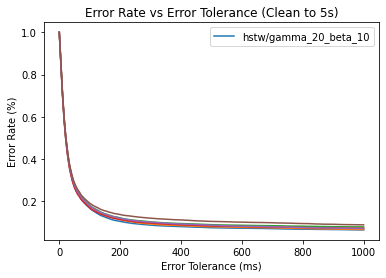

In [12]:
for curve in allErrors:
    plt.plot(curve[0])

plt.xlabel('Error Tolerance (ms)')
plt.ylabel('Error Rate (%)')
plt.legend(folder_names)
plt.title('Error Rate vs Error Tolerance (Clean to 5s)')
plt.show()

In [11]:
def plotAlignment(timesToPlot, systemsToPlot, legend, cfg, title="Alignment Error Rates"):
    fig, axs = plt.subplots(1, len(timesToPlot), figsize = (11, 7))
    x = np.arange(4)
    numBars = len(systemsToPlot)
    width = 0.75 / numBars
    
    for i, plotTime in enumerate(timesToPlot):
        
        axs[i].grid(zorder=0)
        for j, plotSys in enumerate(systemsToPlot):
            errorsFile = '/home/%s/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss/%s.pkl' \
                % (user, cfg, str(plotTime), plotSys)
            errorCurve = calc_error_rates(errorsFile, 1000)[0]
            axs[i].bar(x - width * (numBars / 2) + (j + 1/2) * width, errorCurve[[20, 50, 100, 200]] * 100, width, zorder = 3)
#         axs[i].set_xlabel("Error Tolerance (ms)")
        axs[i].set_xticks(x)
        axs[i].set_xticklabels([20, 50, 100, 200], fontsize="small")
        axs[i].set_ylim(0,80)
        axs[i].set_title("L = " + str(plotTime))

    plt.legend(legend, loc = (1.1, 0.5))
    fig.suptitle(title, fontsize = 'x-large')
    axs[0].set_ylabel("Error Rate (%)", fontsize = "large")
    axs[len(timesToPlot) // 2].set_xlabel("Error Tolerance (ms)", fontsize = "large")
    fig.tight_layout()

In [12]:
savefile_names

['dtw233.pkl',
 'dtw111.pkl',
 'nwtw_gamma_1.pkl',
 'nwtw_gamma_0.2.pkl',
 'hstw_gamma_10_beta_150.pkl']

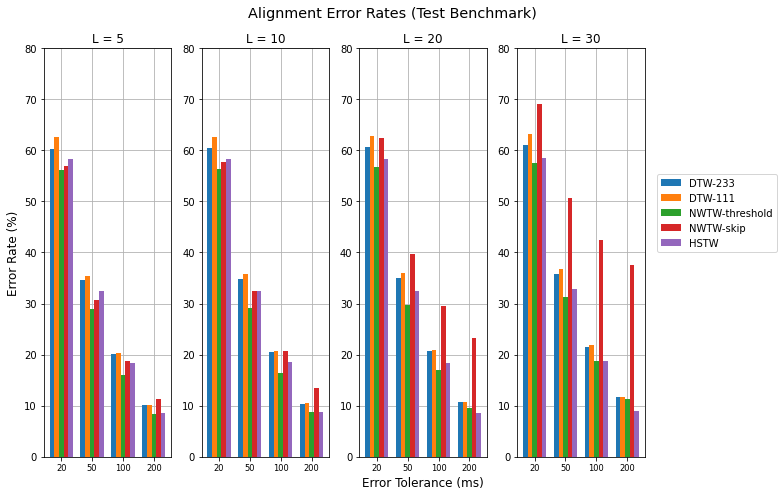

In [12]:
# Test Benchmark Alignment Plot
timesToPlot = times
systemsToPlot = ['dtw233', 'dtw111', 'nwtw_gamma_1','nwtw_gamma_0.2', 'hstw_gamma_10_beta_150']
legend = ["DTW-233", "DTW-111", "NWTW-threshold", "NWTW-skip","HSTW"]
cfg = cfg

plotAlignment(timesToPlot, systemsToPlot, legend, cfg, title="Alignment Error Rates (Test Benchmark)")

## Attribution

### Functions

In [13]:
def eval_attribution(hypdir, query_list, hop_sec, annot_file, \
                     savefile = None, scoring_collar = 0.1, sr = 22050, planeAttrib = True):
    '''
    Evaluate the attribution task
    '''
    
    df = pd.read_csv(annot_file)
    allTimestamps = df.set_index('name').to_dict(orient='index')
    attributions = []
    
    # ************************************************************************************************************
    # This section should be easily parallelizable with a starmap
    # Just turn the inputs to evalQuery into a list, 
    #     starmap evalQuery, and store the results in a list called attributions
    with open(query_list, 'r') as f:
        for line in f:
            theseAttributions = evalQuery_attrib(line, allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr, planeAttrib)
            if len(theseAttributions) > 0:
                attributions.append(theseAttributions)
                
    # ************************************************************************************************************
    
    attributions = np.vstack(attributions)
    
    
    if savefile is not None:
        if planeAttrib:
            outdir = os.path.dirname(savefile)
            outdir = Path(outdir)
            outdir.mkdir(parents=True, exist_ok=True)
            pkl.dump(attributions, open(savefile, 'wb'))
            return attributions
        else:
            ROC = calc_ROC(attributions)
            #return attributions
            if savefile is not None:
                outdir = os.path.dirname(savefile)
                outdir = Path(outdir)
                outdir.mkdir(parents=True, exist_ok=True)
                pkl.dump(ROC, open(savefile, 'wb'))

            return ROC

In [14]:
def evalQuery_attrib(line, allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr, planeAttrib):
    scoring_collar_frames = int(scoring_collar / hop_sec)

    parts = line.strip().split()
    assert len(parts) == 2
    basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
    hypfile = hypdir + '/' + basename + '.pkl'

    if not os.path.exists(hypfile):
        print(hypfile)
        print("X", end='')
        return np.array([])

    hypalign = pkl.load(open(hypfile, 'rb'))
    if hypalign is not None:
        path = hypalign['wp']

        times = allTimestamps[os.path.basename(parts[0]) + ".wav"]

        firstRepEndTime = times['beginning replacement end (idx)'] / sr
        midRepStartTime = times['middle replacement start (idx)'] / sr
        midRepEndTime = times['middle replacement end (idx)'] / sr
        lastRepStartTime = times['ending replacement start (idx)'] / sr
        boundaries = np.array([firstRepEndTime, midRepStartTime, midRepEndTime, lastRepStartTime])

        gt = getAttributionGT(path, boundaries, scoring_collar, hop_sec)
    
        # Impute cost scores or plane attributions
        if planeAttrib:
            preds = np.interp(np.arange(path[-1,0]), path[:,0], path[:,2])
            preds = np.ceil(preds) # If frame is in both planes, default to visible (match)
            
        # Interpolate here to fill in the frames that the path jumps over
        else:
            preds = np.interp(np.arange(path[-1,0]), path[:,0], hypalign["costs"])

        attributions = np.hstack((gt.reshape((-1,1)), preds.reshape((-1,1))))
        
        collarFilter = gt >= 0
        attributions = attributions[collarFilter, :]
        return attributions
    
    else:
#         print("X", end='')
        return np.array([])

In [15]:
def getAttributionGT(path, boundaries, scoring_collar, hop_sec):
    query_length = path[-1,0]
    boundaryFrames = np.round(boundaries / hop_sec).astype(int)
    # Assemble gt with no scoring collar
    gt = np.zeros(query_length)
    gt[boundaryFrames[0]:boundaryFrames[1]] = 1
    gt[boundaryFrames[2]:boundaryFrames[3]] = 1
    
    # Apply scoring collar:
    for boundary in boundaries:
        collarStartTime = boundary - scoring_collar
        collarStartFrame = int(np.ceil(collarStartTime / hop_sec))
        collarEndTime = boundary + scoring_collar
        collarEndFrame = int(np.ceil(collarEndTime / hop_sec))
        gt[collarStartFrame:collarEndFrame] = -1
    
    return gt

In [16]:
def calc_ROC(attributions):
    flippedGT = (attributions[:,0] == 0).astype(int)
    fps, tps, thresholds = metrics.roc_curve(flippedGT, attributions[:,1])
    return np.array([thresholds, 1-tps, fps]).T

In [17]:
def planeAttribToFPFN(paFile):
    attribs = pkl.load(open(paFile, 'rb'))
    diffs = attribs[:,1] - attribs[:,0] # 0 for correct, 1 for fp, -1 for fn
    fp = np.sum(diffs == 1) / (np.sum(attribs[:,0] == 0)) # num fp / num true neg
    fn = np.sum(diffs == -1) / (np.sum(attribs[:,0] == 1)) # num fn / num true pos
    return fp, fn

### Evaluate Plane Attribution

In [18]:
savefile_names

['dtw233.pkl',
 'dtw111.pkl',
 'nwtw_gamma_1.pkl',
 'nwtw_gamma_0.2.pkl',
 'hstw_gamma_10_beta_150.pkl']

In [ ]:
allAttr = []
for t in times:
    EXPERIMENTS_ROOT = '/home/%s/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (user, cfg, t)
    EVALUATIONS_ROOT = '/home/%s/ttmp/partial_match/%s/evaluations/attribution_plane/align_clean_to_%ss' % (user, cfg, t)
    ts = '/home/%s/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % (user, t)
    start = time.time()

    for i in range(len(savefile_names) - 2, len(savefile_names)):
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        hypdir = EXPERIMENTS_ROOT + "/" + folder_names[i]
        print(hypdir)

        attr = eval_attribution(hypdir, query_list, hop_sec, ts, savefile = savefile, scoring_collar = 0.1, planeAttrib=True)
        allAttr.append(attr)
    print('Took ', time.time() - start)

In [19]:
def plotPlaneAttr(systemsToPlot, legend, timesToPlot=[5,10,15,20,25,30]):
    # find attribution
    planeAttr = np.zeros((len(timesToPlot), len(systemsToPlot)))
    for i, t in enumerate(timesToPlot):
        EVALUATIONS_ROOT = '/home/%s/ttmp/partial_match/%s/evaluations/attribution_plane/align_clean_to_%ss/' % (user, cfg, t)
        
        for j, f in enumerate(systemsToPlot):
            fp, fn = planeAttribToFPFN(EVALUATIONS_ROOT + f)
            planeAttr[i, j] = (fp + fn) / 2
            
    # plot attribution
    x = np.arange(len(timesToPlot))
    numBars = len(systemsToPlot)
    width = 0.75 / numBars

    for i in range(numBars):
        plt.bar(x - width * (numBars / 2) + (i + 1/2) * width, planeAttr[:,i] * 100, width)
        print(planeAttr[:,i] * 100)

    plt.ylim(0,100)
    plt.ylabel("Plane Attribution")

    plt.xlabel("Edit Duration (s)")
    plt.xticks(x, timesToPlot)

    plt.legend(legend, bbox_to_anchor=(1.05, 1))
    plt.title("Plane Attribution For Various Systems and Edit Lengths")
    
    return planeAttr

[20.22921085 20.86299237 22.41883989 24.13029923]
[11.72626864 10.23951262  9.23291499  9.75019896]


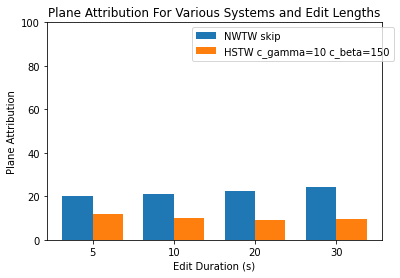

In [22]:
# test benchmark results ends fixed
# allgammas = gammas
systemsToPlot = ['nwtw_gamma_0.2.pkl', 'hstw_gamma_10_beta_150.pkl']
legend = ["NWTW skip", "HSTW c_gamma=10 c_beta=150"]
paaer_errs = plotPlaneAttr(systemsToPlot, legend, timesToPlot=times)

In [24]:
nwtw_skip = paaer_errs[:,0]
hstw_plane = paaer_errs[:,1]

### Evalute Threshold Attribution

In [27]:
def findEER(ROC):
    '''
    Calculates Equal Error Rate based on ROC
    
    '''
    minDiff = np.inf
    savedFP = 0
    savedFN = 0

    for rate in ROC:
        FP = rate[1]
        FN = rate[2]

        if np.abs(FP - FN) < minDiff:
            minDiff = np.abs(FP - FN)
            savedFP = FP
            savedFN = FN
            
    return savedFP, savedFN, minDiff

In [ ]:
ROCCurves = []
for t in times:
    EXPERIMENTS_ROOT = '/home/%s/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (user, cfg, t)
    EVALUATIONS_ROOT = '/home/%s/ttmp/partial_match/%s/evaluations/attribution/align_clean_to_%ss' % (user, cfg, t)

    ts = '/home/%s/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % (user, t)
    start = time.time()
    for i in range(len(savefile_names)):
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        hypdir = EXPERIMENTS_ROOT + "/" + folder_names[i]
        print(hypdir)

        ROC = eval_attribution(hypdir, query_list, hop_sec, ts, savefile = savefile, scoring_collar = 0.1, planeAttrib=False)
        ROCCurves.append(ROC)
    print('Took ', time.time() - start)

In [33]:
timesToPlot = times
systemsToPlot = ['dtw233', 'dtw111', 'nwtw_gamma_1', 'hstw_gamma_10_beta_150']
EERs = np.zeros((len(timesToPlot), len(systemsToPlot)))
for i, plotTime in enumerate(timesToPlot):
    for j, plotSys in enumerate(systemsToPlot):
        ROCfile = '/home/%s/ttmp/partial_match/%s/evaluations/attribution/align_clean_to_%ss/%s.pkl' \
        % (user, cfg, str(plotTime), plotSys)
        ROC = pkl.load(open(ROCfile, 'rb'))
        FP, FN, minDiff = findEER(ROC)
        EERs[i,j] = (FP + FN) / 2 # Take the average of the FP and FN rates when they are at the closest point

threshold_errs = np.array(EERs).T
errs = [threshold_errs[0], threshold_errs[1], threshold_errs[2], nwtw_skip, threshold_errs[3], hstw_plane]

In [34]:
errs

[array([0.14131154, 0.14004521, 0.14349383, 0.14709323]),
 array([0.14193387, 0.14064484, 0.14403146, 0.14761393]),
 array([0.14740182, 0.14395803, 0.14509582, 0.15035515]),
 array([0.20229211, 0.20862992, 0.2241884 , 0.24130299]),
 array([0.1244101 , 0.11760984, 0.1158842 , 0.11427838]),
 array([0.11726269, 0.10239513, 0.09232915, 0.09750199])]

### Figures

Errors for test benchmark (in percentage): 
```
errs = [[14.131154, 14.004521, 14.349383, 14.709323],  # dtw-233 
  [14.193387, 14.064484, 14.403146, 14.761393],   # dtw-111
  [14.740182, 14.395803, 14.509582, 15.035515],  # nwtw-threshold
 [20.22921085, 20.86299237, 22.41883989, 24.13029923],  # nwtw-skip
  [12.44101 , 11.760984, 11.58842 , 11.427838],  # hstw-threshold
 [11.72626864, 10.23951262, 9.23291499, 9.75019896]]  # hstw-skip
 ```

In [8]:
legend = ['DTW-233', 'DTW-111', 'NWTW-threshold', 'NWTW-skip*', 'HSTW-threshold', 'HSTW-plane*']

In [49]:
def plotFinalAttribution(timesToPlot, errs, legend, title=None, savefile=None):
    
    x = np.arange(len(timesToPlot))
    numBars = len(errs)
    
    width = 0.75 / numBars
    plt.grid(zorder=0)
    
    colors = [plt.cm.Set1(i) for i in range(5)]
    colors.append("#dced31")
    colors = colors[::-1]
    
    for i in range(numBars):
        plt.bar(x - width * (numBars / 2) + (i - 1/2) * width , errs[i]*100, width, zorder=3, color=colors[i])
    
#     plt.ylim(0,100)
    plt.ylim(0,25)
    plt.ylabel("Equal Error Rate (%)")
    
    plt.xlabel("Edit Duration (s)")
    plt.xticks(x, timesToPlot)
    
    plt.legend(legend, loc = (0.01, 0.85), ncol=3, fontsize='small', framealpha=0.6, columnspacing=1.9)
#     plt.legend(legend, loc=(1.01, 0.5))
    plt.title(title)
    if savefile:
        plt.savefig(savefile, dpi=300)

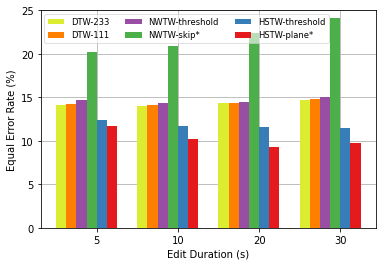

In [51]:
# plt.legend(legend, loc = (0.1, 0.62), ncol=3, fontsize='small', framealpha=0.6)
plotFinalAttribution(times, errs, legend, savefile="/home/{}/ttmp/partial_match/test_benchmark/attibution.jpg".format(user))